# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Import to replace all the NaN values
from sklearn.impute import SimpleImputer

# Feature scaler and PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Import to sort a dictionary (used for PCA)
from operator import itemgetter

# Import for clustering
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

#Let's take a look at the azdias dataset first
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.shape

(891221, 85)

In [5]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


Let's also look at the type of values for each feature.

In [6]:
type_dict = {}
for col in azdias:
    type_dict[col] = type(azdias[col][0])

type_cast = pd.Series(type_dict)
type_cast

AGER_TYP                   <class 'numpy.int64'>
ALTERSKATEGORIE_GROB       <class 'numpy.int64'>
ANREDE_KZ                  <class 'numpy.int64'>
CJT_GESAMTTYP            <class 'numpy.float64'>
FINANZ_MINIMALIST          <class 'numpy.int64'>
FINANZ_SPARER              <class 'numpy.int64'>
FINANZ_VORSORGER           <class 'numpy.int64'>
FINANZ_ANLEGER             <class 'numpy.int64'>
FINANZ_UNAUFFAELLIGER      <class 'numpy.int64'>
FINANZ_HAUSBAUER           <class 'numpy.int64'>
FINANZTYP                  <class 'numpy.int64'>
GEBURTSJAHR                <class 'numpy.int64'>
GFK_URLAUBERTYP          <class 'numpy.float64'>
GREEN_AVANTGARDE           <class 'numpy.int64'>
HEALTH_TYP                 <class 'numpy.int64'>
LP_LEBENSPHASE_FEIN      <class 'numpy.float64'>
LP_LEBENSPHASE_GROB      <class 'numpy.float64'>
LP_FAMILIE_FEIN          <class 'numpy.float64'>
LP_FAMILIE_GROB          <class 'numpy.float64'>
LP_STATUS_FEIN           <class 'numpy.float64'>
LP_STATUS_GROB      

Notes: at a first glance at the dataset, we notice that:
- we have the number of rows and features expected
- the range of the values in each column differs
- some columns contain integers, other floats
- some columns are missing values

In [7]:
# Now let's take a look at the features summary

feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,KK_KUNDENTYP,person,ordinal,[-1]
freq,1,43,49,26


Notes: at a first glance at this second dataset, we notice that:
- we have the number of rows expected (one row per feature)
- the missing or unknown column provides an insight on the values we are expecting to find if we have missing or unknown values
- it could be that some columns of the azdias dataset have a lot of these (the AGER_TYPE column in first place, where 75% at least of the values are equal to -1)

Preprocessing appears like a mandatory step, where we will replace the unknown and missing values, and decide which features to keep for the analysis.


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
# Identify missing or unknown data values and convert them to NaNs.

azdias.isnull().sum().sum()

4896838

The azdias dataset contains 4 896 838 missing or unknown values, that we are going to replace with NaN values. 
Let's first parse the feat_info 'missing_or_unknown' column to be able to use the values provided.

In [10]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


We need to remove the square brakets, and convert the remaining string to a list. 

In [11]:
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")

def parser(data):
    rows = data.shape[0]
    # we store the parsed list in a dictionary
    new_list = {}
    for row in range(0,rows):
        #our input is the content of the missing_or_unknown column
        content_to_parse = data.iloc[row,3]
        list_elem = content_to_parse.strip('[').strip(']')
        list_elem = list_elem.split(',')
        if list_elem!=['']:
            new_list[row]=list_elem
        else:
            new_list[row]=[]
    return new_list

feat_info['NaN values'] = np.nan
dic_parsed = parser(feat_info)

#we store the parsed values in the dataframe
for key in dic_parsed.keys():
    feat_info['NaN values'][key]= dic_parsed[key]

feat_info

/Users/acoullandreau/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/acoullandreau/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,attribute,information_level,type,missing_or_unknown,NaN values
0,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1]
5,FINANZ_SPARER,person,ordinal,[-1],[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1],[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1],[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1],[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1],[-1]


Note: we saw the warning, but it appears that the values of the NaN values column are as expected (a list of strings). 


In [12]:
print("Type of the values in the NaN values column")
print(type(feat_info['NaN values'][0]))
print()
print("Type of each element of the list")
print(type(feat_info['NaN values'][0][0]))

Type of the values in the NaN values column
<class 'list'>

Type of each element of the list
<class 'str'>


Let's build a function to cast the elements of each list to float or interger, to ease the comparison later on with the azdias dataset.

In [13]:
def cast_num_list(num_list, target_type, ignore_list):
    for i in range(0, len(num_list)):
        if num_list[i] not in ignore_list:
            if target_type == 'float':
                num_list[i] = float(num_list[i])
            elif target_type == 'int':
                num_list[i]= int(num_list[i])

def cast_list_serie(serie, target_type, ignore_list):
    for row in serie:
        cast_num_list(row, target_type, ignore_list)


cast_list_serie(feat_info['NaN values'], 'float', ['X', 'XX'])
feat_info

,attribute,information_level,type,missing_or_unknown,NaN values
0,AGER_TYP,person,categorical,"[-1,0]","[-1.0, 0.0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1.0, 0.0, 9.0]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1.0, 0.0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0.0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1.0]
5,FINANZ_SPARER,person,ordinal,[-1],[-1.0]
6,FINANZ_VORSORGER,person,ordinal,[-1],[-1.0]
7,FINANZ_ANLEGER,person,ordinal,[-1],[-1.0]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1],[-1.0]
9,FINANZ_HAUSBAUER,person,ordinal,[-1],[-1.0]


In [14]:
print("Type of the values in the NaN values column")
print(type(feat_info['NaN values'][0]))
print()
print("Type of each element of the list")
print(type(feat_info['NaN values'][0][0]))

Type of the values in the NaN values column
<class 'list'>

Type of each element of the list
<class 'float'>


Now in the last column of feat_info_copy we have a list of the values we should look for in the azdias dataset to replace them by NaN values. Note that we will need to cast the values in the azdias dataset to string to be able to compare it with the NaN values of the summary dataset.

In [15]:
#we simplify the summary dataframe and transpose it for ease of use later on
feat_summary = feat_info.copy()
feat_summary.drop(['information_level', 'type', 'missing_or_unknown'], axis=1, inplace=True)
feat_summary.set_index('attribute', inplace=True)
feat_summary = feat_summary.T

feat_summary

attribute,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
NaN values,"[-1.0, 0.0]","[-1.0, 0.0, 9.0]","[-1.0, 0.0]",[0.0],[-1.0],[-1.0],[-1.0],[-1.0],[-1.0],[-1.0],...,[-1.0],[-1.0],[-1.0],[-1.0],"[-1.0, 0.0]",[-1.0],[-1.0],"[-1.0, 9.0]","[-1.0, 0.0]","[-1.0, 9.0]"


In [16]:
def replace_NaN(dataset, NaN_summary):
    for col in NaN_summary:
        #for each feature, we are going to go through the values of the azdias dataset and compare it with the NaN values
        NaN_values = NaN_summary[col][0]
        dataset.replace({col: NaN_values}, np.nan, inplace=True)

replace_NaN(azdias, feat_summary)


In [17]:
azdias.isnull().sum().sum()

8373929

The total amount of missing values in the dataset is now 8 373 929. It is reasonably more than what we first estimated, which makes sense as we "converted" some numerical values into missing values.
We now have a dataset with all missing and unknown values set to NaN, let's assess how they are spread in the data.

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [18]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

azdias.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

It appears that the distribution of missing data is inequally spread among the features: where some features have a few missing data, others have more than 10% of their rows with NaN values. 
Let's plot this information on a histogram.

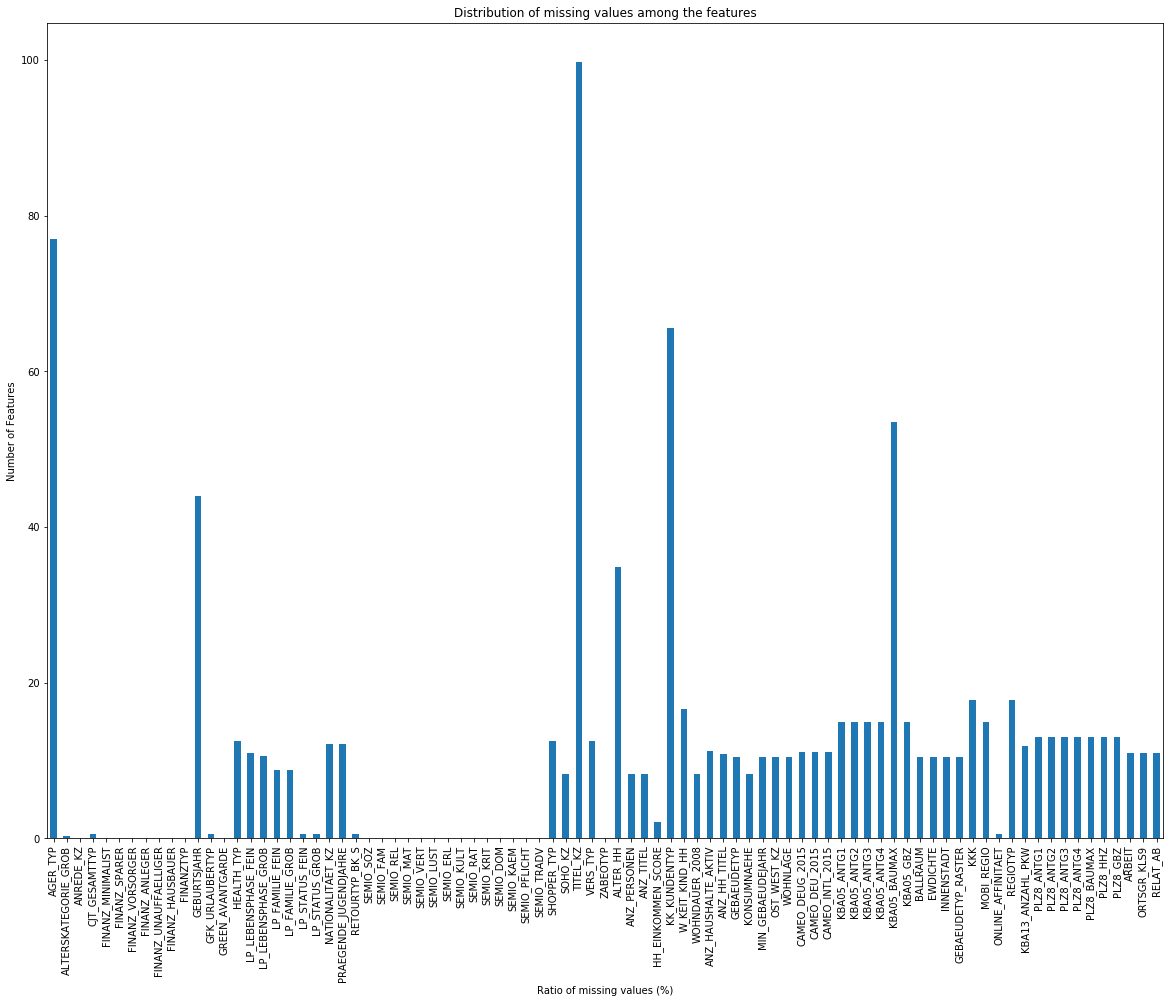

In [19]:
# Investigate patterns in the amount of missing data in each column.

#We are going to plot the ratio of missing values in the dataset (in %)
ratio = (azdias.isnull().sum()/len(azdias))*100

ratio.plot.bar(figsize=(20,15))
plt.ylabel('Number of Features')
plt.xlabel('Ratio of missing values (%)')
plt.title('Distribution of missing values among the features')
plt.show()

From this histogram, we see that:
- 6 features have more than 20% missing value
- about one third of the features have much less than 5% missing values
- about half of the features have around 10-15% missing values

At a first glance, it looks clear that the outliers are from the first category, with more than 20% missing values. Let's list these features to evaluate whether it is relevant to drop them. 

In [20]:
outliers = ratio[ratio>20]
outliers

AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64

Based on the meaning of each of these features, we get to the following conclusions:

- TITEL_KZ (Academic title flag) would apply to part of the demographic sample, which is why for over 99% of the dataset it is set as unknown. 

--> We therefore assume we can safely drop this feature.

- AGER_TYP provides information regarding the age of the individual. However, there are a few other features that allow to have an idea of the range of age of the individual or people in his/her environment (ALTERSKATEGORIE_GROB, LP_LEBENSPHASE_FEIN, ALTER_HH, CAMEO_INTL_2015). The percentage of unknown is so high anyway that it makes very little sense to keep this feature

--> We therefore assume we can safely drop this feature.

- It gets more complicated for both GEBURTSJAHR and ALTER_HH, also related to the age. The percentage of missing values is less than half. As it is still significantly more than the other features, and to avoid balance problems in the number of values analysed in the dataset, we decide to remove these two features as well.

--> We decide to drop these features.

- KK_KUNDENTYP (Consumer pattern over past 12 months). Similarly to the age related features, we can have an idea of the consumer behaviours of an idividual based on other features (such as CJT_GESAMTTYP, CAMEO_DEUG_2015, CAMEO_DEU_2015, ZABEOTYP).

--> We therefore assume we can safely drop this feature.

- KBA05_BAUMAX (Most common building type within the microcell), same approach, other features (such as WOHNLAGE, KBA05_ANTG1 to KBA05_ANTG4, KBA05_GBZ) provide an insight on the neighborhood of an individual.

--> We therefore assume we can safely drop this feature.



In [21]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias = azdias.drop(outliers.index, axis=1)
#we save the list of dropped columns for later
azdias_dropped_col = outliers.index.tolist()

In [22]:
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

Let's summarize here our observations and the decisions taken to drop some features.
We noticed after plotting the percentage of missing values in each column three situations:
- some features had reasonably more than 20% missing values
- about half of the features had between 10% and 15% missing values
- about one third of the features had much less tha 5% missing values

The outliers were clearly in the first category, a list of 6 features.
Using the Data_Dictionary.md file that describes each feature, we got to the following conclusions:
AGER_TYP (76.955435), TITEL_KZ (99.757636), KK_KUNDENTYP (65.596749) and KBA05_BAUMAX (53.468668) can be safely dropped as other features provide a significant insight on similar characteristics of an individual and his/her surroundings. 
For both GEBURTSJAHR (44.020282) and ALTER_HH (34.813699), it is not as evident as we would let go of possibily relevant information. However, the percentage of missing values being much higher than the rest of the features, we prefer to drop them as well as to avoid unbalancing the analysis. 

After removing the 6 outliers, we confirm that the shape of the dataset is updated (79 remaining features).

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [23]:
# How much data is missing in each row of the dataset?

miss_row = azdias.isnull().sum(axis=1)
miss_row.describe()

count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

It looks like 75% of the rows have less than 3 missing values, and on average each row has about 5 missing values. Let's plot this serie to see if we confirm this pattern and manage to split the rows into two groups. 

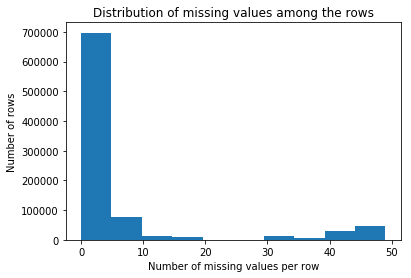

In [24]:
plt.hist(miss_row)
plt.ylabel('Number of rows')
plt.xlabel('Number of missing values per row')
plt.title('Distribution of missing values among the rows')
plt.show()


The histogram allows to clearly distinguish two groups:
- the rows that have less than 20 missing values
- the rows that have more than 29 missing values

Let's note that the distribution appears to be right-skewed, which is coherent with the value of the third quartile (Q3=3 < 20). 

We will therefore use the value 20 to split the rows into two groups. Let's call the two subsets azdias_few_missing and azdias_many_missing. 

In [25]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

azdias_few_missing = azdias[miss_row <= 20]
azdias_many_missing = azdias[miss_row > 20]

print(azdias_few_missing.shape)
print(azdias_many_missing.shape)

(797426, 79)
(93795, 79)


We confirm that the whole dataset is properly split in two groups by ensuring the shape of the two subsets matches the shape of the original dataset. 

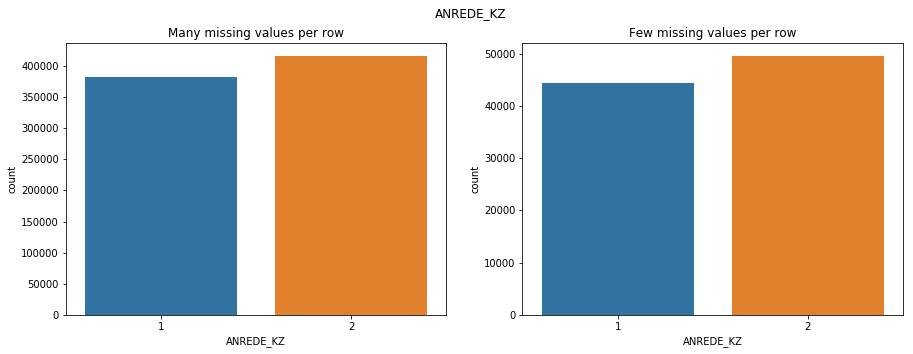

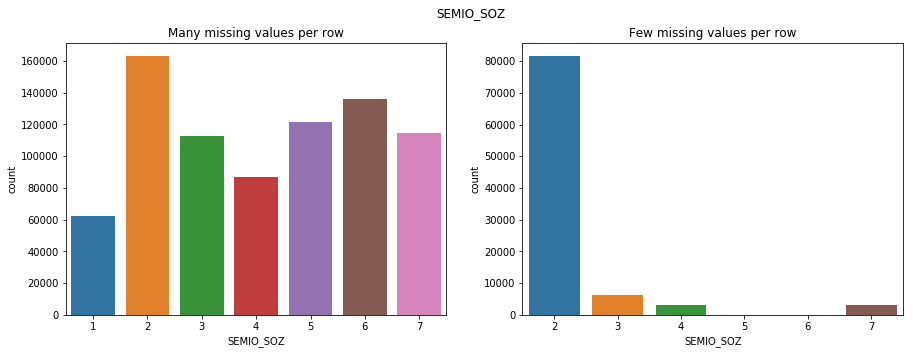

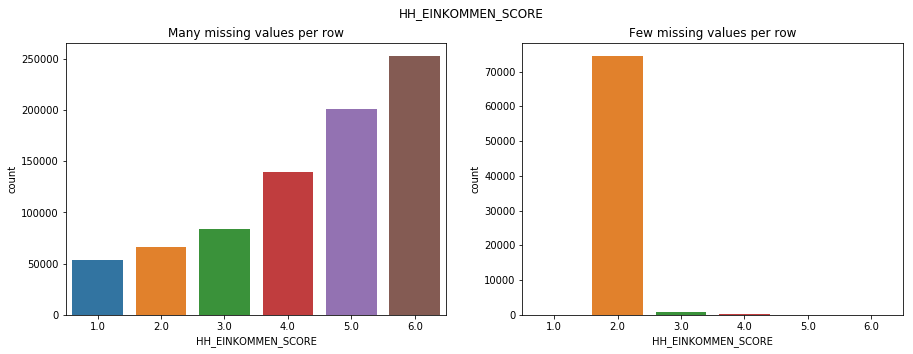

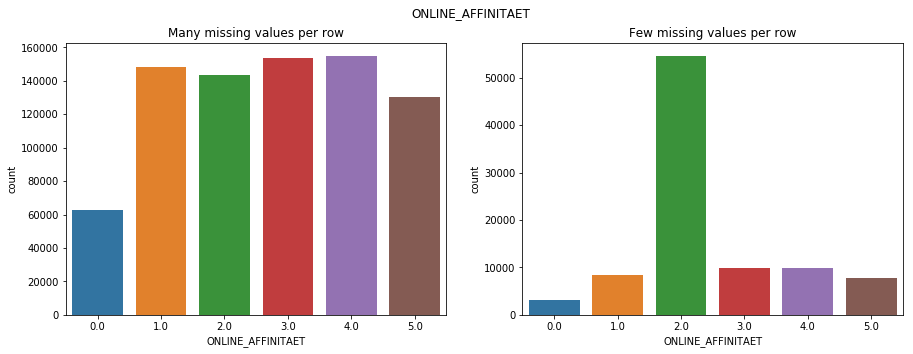

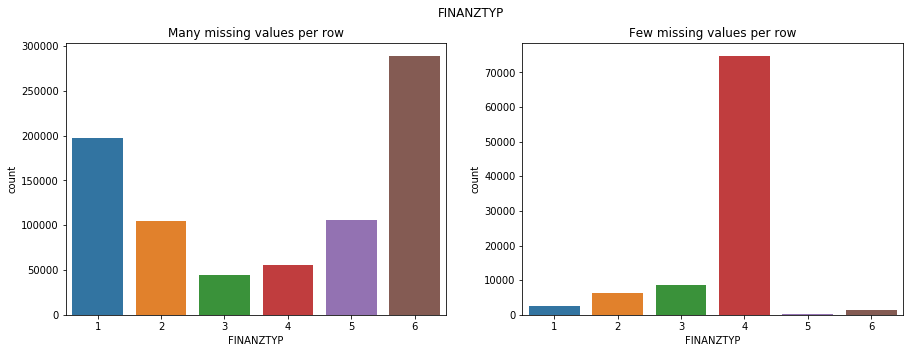

In [26]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

#We first define a function to be able to perform the comparison multiple times with different columns on the two subsets
def compare_distr(subset_1, subset_2, columns):
    for column in columns:
        plot = plt.figure(figsize=(15,5))
        axis_1 = plot.add_subplot(1, 2, 1)
        axis_1.title.set_text('Many missing values per row')
        sns.countplot(subset_1[column])

        axis_2 = plot.add_subplot(1, 2, 2)
        axis_2.title.set_text('Few missing values per row')
        sns.countplot(subset_2[column]);

        plot.suptitle(column)
        plt.show()    
    
compare_distr(azdias_few_missing, azdias_many_missing,['ANREDE_KZ','SEMIO_SOZ', 'HH_EINKOMMEN_SCORE', 'ONLINE_AFFINITAET','FINANZTYP'])



#### Discussion 1.1.3: Assess Missing Data in Each Row

Out of the five columns we selected, we can observe two different situations:
- the case of the columns ANREDE_KZ, SEMIO_SOZ and ONLINE_AFFINITAET (3/5)
- the case of the columns HH_EINKOMMEN_SCORE and FINANZTYP (2/5)

In the first case, it looks that the distribution of values for the subset 'many missing values' represents a low proportion compared to the distribution of values for the subset 'few missing values'. If we look at the column SEMIO_SOZ for example, we see that the most represented value is 2 in the subset 'many missing values', in high proportion in the subset 'few missing values'. It means that if we were to drop the rows from the subset 'many missing values', we would still have a distribution of values comparable to the orignial dataset. 

However with the second case, the observation is different. Dropping the rows from the subset 'many missing values' would have an impact on the global distribution of values in the new dataset. 

This brings us to conclude that performing the analysis on only 5 columns out of 79 is not enough to know whether to drop the rows or not. 
In order to decide, we should build a score system that would let us be able to vote whether to drop or not the rows. As a matter of fact, if it appears that for the majority of the columns it is not risky to let go of the subset 'many missing values', although for some columns it may have an impact it would be minimal. The idea of this score system would be to evaluate the proportion difference between the two subsets and the whole dataset, and assign a 'safety score' to each column based on the result. Then comparing the scores of all columns we would have an idea of the effect of dropping the row from the subset 'many missing values'. 


In [27]:
# This function can be used if necessary to identify whether the subset 'many missing values' should be dropped.
# The sensibility can be adjusted to be more aggressive or more tolerant with the noise this subset may create

def drop_rows(subset_1, dataset, tolerance):
    results = calc_score(subset_1, dataset, tolerance)
    sum_true = sum(value == True for value in results.values())
    sum_false = sum(value == False for value in results.values())
    ratio_true_false = (sum_true/sum_false)*100
    ratio_true_false = float('%.2f'%(ratio_true_false))
    print('With a tolerance of {0}, it seems relevant to drop the rows for {1}% of the features'.format(tolerance,ratio_true_false))
    
def calc_score(subset_1, dataset, tolerance):
    score_dict = {}
    for col in dataset:
        ratio = calc_ratio(subset_1, dataset, col)
        ratio=ratio.tolist()
        if max(ratio) >= tolerance:
            score = True
        else:
            score = False
        score_dict[col] = score
    return score_dict

def calc_ratio(subset_1, dataset, column):
    column_values = dataset[column].unique()
    for column_value in column_values:
        if column_value != 'nan':
            ratio= subset_1[column].value_counts()/dataset[column].shape[0]
        return ratio
    
    
drop_rows(azdias_many_missing, azdias, 0.1)

With a tolerance of 0.1, it seems relevant to drop the rows for 1.28% of the features


*Note on the use of this function:*


The idea is to pass the subset to analyse along with the original dataset. If the difference of proportion between the two subsets for the same unique value of the column gets above the given threshold (tolerance), we consider that for this column it is safer to drop the rows. Otherwise, the columns 'votes' to keep the row as it is not dangerous. 

The percentage provided as a output is the proportion of columns that voted to drop the rows. If this percentage is low, we can assume keeping the 'many_missing_values' subset will have a low impact. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [28]:
# How many features are there of each data type?

feat_info

,attribute,information_level,type,missing_or_unknown,NaN values
0,AGER_TYP,person,categorical,"[-1,0]","[-1.0, 0.0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1.0, 0.0, 9.0]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1.0, 0.0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0.0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1.0]
5,FINANZ_SPARER,person,ordinal,[-1],[-1.0]
6,FINANZ_VORSORGER,person,ordinal,[-1],[-1.0]
7,FINANZ_ANLEGER,person,ordinal,[-1],[-1.0]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1],[-1.0]
9,FINANZ_HAUSBAUER,person,ordinal,[-1],[-1.0]


In [29]:
feat_info.groupby('type').count()

,attribute,information_level,missing_or_unknown,NaN values
type,,,,
categorical,21,21,21,21
interval,1,1,1,1
mixed,7,7,7,7
numeric,7,7,7,7
ordinal,49,49,49,49


It looks like we need to take a closer look at 21 categorical type columns and 7 mixed type columns.
The remaining 57 columns will be left as-is.

Note: among those columns, some were dropped earlier from the dataset, thus it won't be necessary to re-encode them.

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [30]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

def categorical_subtype(cat_dataset, ignored_columns, ref_dataset):
    binary = []
    multi_level = []
    for row in cat_dataset:
        if row not in ignored_columns:
            col_values = ref_dataset[row].unique()
            num_unique_values = len(col_values)
            if pd.isnull(col_values).any():
                num_unique_values = num_unique_values - 1
            if num_unique_values > 2:
                multi_level.append(row)
            else:
                binary.append(row)
    print('List of binary columns: ', binary)
    print()
    print('List of multi-level columns: ', multi_level)

categorical = feat_info['attribute'][feat_info['type']=='categorical']
categorical_subtype(categorical, azdias_dropped_col, azdias)


List of binary columns:  ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

List of multi-level columns:  ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


The function above provide the list of binary categorical columns, along with the multi-level categorical columns. The columns that were dropped before are already out of those lists.

Binary columns don't need to be re-encoded, to the exception of OST_WEST_KZ that accepts 'W' as one of the values.

Let's look at the multi-level categorical columns, is there any we could drop at this stage?

Some of the columns are very similar to each other, one with a rough scale, the other one with a fine scale. It seems relevant at this stage to let go of the fine scale features (they present more different values which complexifies the analysis). We will therefore drop the following features:

- GFK_URLAUBERTYP
- LP_FAMILIE_FEIN
- LP_STATUS_FEIN
- CAMEO_DEU_2015

As for the other features, they present some interest for the analysis. As a result, it appears that the following columns are to be re-encoded:
- OST_WEST_KZ
- LP_FAMILIE_GROB
- LP_STATUS_GROB
- NATIONALITAET_KZ
- SHOPPER_TYP
- ZABEOTYP
- GEBAEUDETYP
- CAMEO_DEUG_2015


In [31]:
# Re-encode categorical variable(s) to be kept in the analysis.

#First let's re-encode the binary feature
azdias_few_missing.replace({'OST_WEST_KZ': {'O':0,'W': 1}}, inplace=True)

# Then let's use one-hot encoding to re-encode the other multi-level features
cat_col_to_encode = ['CJT_GESAMTTYP', 'FINANZTYP', 'LP_FAMILIE_GROB',
                       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP',
                       'GEBAEUDETYP', 'CAMEO_DEUG_2015']

def encode_cat_col(dataset, col_to_encode):
    cat_col_encoded_dict = {}
    #Using one-hot encoding
    for column in col_to_encode:
        cat_col_encoded = pd.get_dummies(dataset[column])
        cat_col_encoded_dict[column]=cat_col_encoded
    return cat_col_encoded_dict

cat_col_encoded_dict = encode_cat_col(azdias_few_missing, cat_col_to_encode)

#We replace the new encoded columns to the subset few missing values
for column in cat_col_to_encode:
    azdias_few_missing.replace({column: cat_col_encoded_dict[column]}, cat_col_encoded_dict[column], inplace=True)

azdias_few_missing

/Users/acoullandreau/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  regex=regex)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2,5.0,1,5,1,5,4,3,4,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,1.0,1,3.0,3,3,4,1,3,2,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,3.0,1,3.0,4,4,2,4,2,2,6,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,3.0,2,4.0,2,4,2,3,5,4,1,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0
10,3.0,2,1.0,2,2,5,3,1,5,6,...,2.0,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0


In [32]:
# We drop the features we do not want to keep for the rest of the analysis
azdias_few_missing.drop(['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015'], axis=1, inplace=True)
azdias_dropped_col.extend(['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015'])


/Users/acoullandreau/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [33]:
azdias_few_missing.shape

(797426, 75)

#### Discussion 1.2.1: Re-Encode Categorical Features

From this re-encoding step of categorical columns, we performed re-encoding on 10 columns (out of the 21 columns with the categorical type). The 11 columns we did not include are either dropped from the original dataset due to their many missing values, binary categoricals, or features that do not appear to be bringing enough additional information compared to how much more complex it may make the analysis. 

In summary, it appears that:

- The following colums are binary
    - ANREDE_KZ
    - GREEN_AVANTGARDE
    - SOHO_KZ
    - VERS_TYP
    - OST_WEST_KZ

- The following columns are dropped at this stage before re-encoding
    - GFK_URLAUBERTYP
    - LP_FAMILIE_FEIN
    - LP_STATUS_FEIN
    - CAMEO_DEU_2015

- The following columns were re-encoded:
    - OST_WEST_KZ 
    - CJT_GESAMTTYP
    - FINANZTYP
    - LP_FAMILIE_GROB
    - LP_STATUS_GROB
    - NATIONALITAET_KZ
    - SHOPPER_TYP
    - ZABEOTYP
    - GEBAEUDETYP
    - CAMEO_DEUG_2015

We re-encoded them using one-hot encoding. Those features were kept and not dropped at this stage as they present information that can be of great value for a company willing to identify potential clients.

The subset azdias_few_missing now contains the columns we want to keep for the analysis, properly encoded (to the exception of the mixed-types features that we take care of below), without the rows missing many values. This is almost our final dataset to work with!


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [34]:
# Let's list the features marked as mixed
mixed = feat_info['attribute'][feat_info['type']=='mixed']

for row in mixed:
    if row not in azdias_dropped_col:
        print(row)

LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB
PRAEGENDE_JUGENDJAHRE
WOHNLAGE
CAMEO_INTL_2015
PLZ8_BAUMAX


In [35]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Create a new feature Mainstream/Avantgarde
movement_dict = {1.0:'0', 2.0:'1', 3.0:'0', 4.0:'1', 5.0:'0', 6.0:'1', 7.0:'1', 8.0:'0',
                 9.0:'1', 10.0:'0', 11.0:'1', 12.0:'0', 13.0:'1', 14.0:'0', 15.0:'1'}

azdias_few_missing.loc[:,'PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_few_missing['PRAEGENDE_JUGENDJAHRE']
azdias_few_missing.replace({'PRAEGENDE_JUGENDJAHRE_MOVEMENT':movement_dict}, inplace=True)

# Create a new feature Decade
decade_dict = {1.0:'0', 2.0:'0', 3.0:'1', 4.0:'1', 5.0:'2', 6.0:'2', 7.0:'2', 8.0:'3',
                 9.0:'3', 10.0:'4', 11.0:'4', 12.0:'4', 13.0:'4', 14.0:'5', 15.0:'5'}

azdias_few_missing.loc[:,'PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_few_missing['PRAEGENDE_JUGENDJAHRE']
azdias_few_missing.replace({'PRAEGENDE_JUGENDJAHRE_DECADE':decade_dict}, inplace=True)

#Let's verify the shapes
print(azdias_few_missing.shape)
print()
print('Shape of the DECADE feature: ', azdias_few_missing['PRAEGENDE_JUGENDJAHRE_DECADE'].shape)
print()
print('Shape of the MOVEMENT feature: ', azdias_few_missing['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].shape)

/Users/acoullandreau/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/acoullandreau/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(797426, 77)

Shape of the DECADE feature:  (797426,)

Shape of the MOVEMENT feature:  (797426,)


In [36]:
#The shapes match, let's look at the values we now have in each new feature

print('Unique values of the DECADE feature\n')
print(azdias_few_missing['PRAEGENDE_JUGENDJAHRE_DECADE'].value_counts())
print('\n')
print('Unique values of the MOVEMENT feature\n')
print(azdias_few_missing['PRAEGENDE_JUGENDJAHRE_MOVEMENT'].value_counts())

Unique values of the DECADE feature

5    225424
3    175105
4    151701
2    114325
1     74272
0     28141
Name: PRAEGENDE_JUGENDJAHRE_DECADE, dtype: int64


Unique values of the MOVEMENT feature

0    593801
1    175167
Name: PRAEGENDE_JUGENDJAHRE_MOVEMENT, dtype: int64


In [37]:
# We drop the original feature
azdias_few_missing.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [38]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Create a new feature Households
household_dict = {'11':'0', '12':'0', '13':'0', '14':'0', '15':'0',
                  '21':'1', '22':'1', '23':'1', '24':'1', '25':'1',
                  '31':'2', '32':'2', '33':'2', '34':'2', '35':'2', 
                  '41':'3', '42':'3', '43':'3', '44':'3', '45':'3', 
                  '51':'4', '52':'4', '53':'4', '54':'4', '55':'4'}

azdias_few_missing.loc[:,'HOUSEHOLD'] = azdias_few_missing['CAMEO_INTL_2015']
azdias_few_missing.replace({'HOUSEHOLD':household_dict}, inplace=True)


# Create a new feature Life stage
azdias_few_missing.loc[:,'LIFE_STAGE'] = azdias_few_missing['CAMEO_INTL_2015']

life_stage_dict = {'11':'0', '12':'1', '13':'2', '14':'3', '15':'4',
                  '21':'0', '22':'1', '23':'2', '24':'3', '25':'4',
                  '31':'0', '32':'1', '33':'2', '34':'3', '35':'4', 
                  '41':'0', '42':'1', '43':'2', '44':'3', '45':'4', 
                  '51':'0', '52':'1', '53':'2', '54':'3', '55':'4'}

azdias_few_missing.replace({'LIFE_STAGE':life_stage_dict}, inplace=True)

#Let's verify the shapes
print(azdias_few_missing.shape)
print()
print('Shape of the HOUSEHOLD feature: ', azdias_few_missing['HOUSEHOLD'].shape)
print()
print('Shape of the LIFE_STAGE feature: ', azdias_few_missing['LIFE_STAGE'].shape)




(797426, 78)

Shape of the HOUSEHOLD feature:  (797426,)

Shape of the LIFE_STAGE feature:  (797426,)


In [39]:
print('Unique values of the HOUSEHOLD feature\n')
print(azdias_few_missing['HOUSEHOLD'].value_counts())
print('\n')
print('Unique values of the LIFE_STAGE feature\n')
print(azdias_few_missing['LIFE_STAGE'].value_counts())

Unique values of the HOUSEHOLD feature

4    223526
1    190508
3    189905
0    119362
2     68122
Name: HOUSEHOLD, dtype: int64


Unique values of the LIFE_STAGE feature

0    244961
3    232660
2    119559
4    116988
1     77255
Name: LIFE_STAGE, dtype: int64


In [40]:
# We drop the original feature
azdias_few_missing.drop('CAMEO_INTL_2015', axis=1, inplace=True)

In [41]:
# We verify that the dataset has the correct shape (expected 77 features)
azdias_few_missing.shape

(797426, 77)

Now let's take a look at the other 4 mixed-type columns:

- LP_LEBENSPHASE_FEIN
- LP_LEBENSPHASE_GROB
- WOHNLAGE
- PLZ8_BAUMAX

Both LP_LEBENSPHASE feature focuses on the life stage, which is described by two variables: the age range and the earning level. It is captured by LP_FAMILIE and LP_STATUS.
Although we dropped the fine scaled LP_FAMILIE and LP_STATUS features, we still have the rough scale features that provide information. 
Therefore, we decide to drop both LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB


In [42]:
azdias_few_missing.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)

In [43]:
azdias_few_missing.drop('LP_LEBENSPHASE_GROB', axis=1, inplace=True)

PLZ8_BAUMAX is considered a mixed-type feature as it describes two situations: PLZ8 region with families or business buildings. The family homes in the PLZ8 region are described in several features (PLZ8_ANTG1, PLZ8_ANTG2, PLZ8_ANTG3, PLZ8_ANTG4). 
Let's see the proportion of values that represent the situation 'mainly business buildings'.

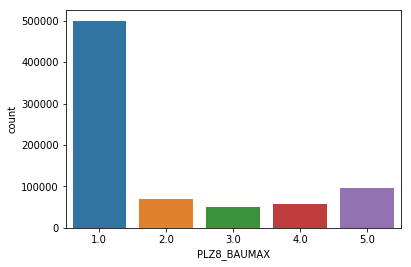

In [44]:
sns.countplot(azdias_few_missing['PLZ8_BAUMAX'])

In proportion, the values related to business buildings are far from being a majority (about 12%). Besides, other features describe comparable pieces of information, such as GEBAEUDETYP_RASTER. 
Therefore, we decide to drop this feature as well. 

In [45]:
azdias_few_missing.drop('PLZ8_BAUMAX', axis=1, inplace=True)

WOHNLAGE is considered a mixed-type feature as it describes two situations: urban neighborhood quality and rural neighborhood flag.
In a row we find values associated with rural neighborhood (7 or 8), there are chances that for other features (such as BALLRAUM, or EWDICHTE) we find values very different than for the rows with urban neighborhood quality values. Therefore keeping this feature as-is should not bring any incoherence later on. 


#### Discussion 1.2.2: Engineer Mixed-Type Features

There are 7 features with a mixed type. 
We first took a closer look at two of them, and engineered new variables from them:

- PRAEGENDE_JUGENDJAHRE

    - It appeared that we could split this feature into two new variables : decade and movement (avantgarde and mainstream)
    - We splitted the feature into two new features PRAEGENDE_JUGENDJAHRE_DECADE and PRAEGENDE_JUGENDJAHRE_MOVEMENT
    - For the movement serie :
    
        - 0 is for mainstream
        - 1 is for avantgarde
        
    - For the decade serie, the decade are split as follow:
    
        - 0 is for 1940
        - 1 is for 1950
        - 2 is for 1960
        - 3 is for 1970
        - 4 is for 1980
        - 5 is for 1990

- CAMEO_INTL_2015

    - It appeared that we could split this feature into two new variables : household and life_stage
    - We noticed that the first digit of the value represents the household category, while the decond digit represents the life stage
            
    - For the household serie, the types are split as follow:
    
        - 0 is for Wealthy Households
        - 1 is for Prosperous Households
        - 2 is for Comfortable Households
        - 3 is for Less Affluent Households
        - 4 is for Poorer Households

    - For the life_stage serie, the stages are split as follow:
    
        - 0 is for Pre-Family Couples & Singles
        - 1 is for Young Couples With Children
        - 2 is for Families With School Age Children
        - 3 is for Older Families &  Mature Couples
        - 4 is for Elders In Retirement


Then we took a look at the other 4 columns with mixed type. 
15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
56                 WOHNLAGE
79              PLZ8_BAUMAX

We decided to drop 3 of them (LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, PLZ8_BAUMAX) and keep as-is the WOHNLAGE feature. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [46]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

azdias_few_missing.shape

(797426, 74)

First let's summarize what we have done until now to prepare our data:

1. We converted all the missing/unknown values to NaN

-> Our dataset still had a shape of (891221, 85)

2. We dropped columns that had too many missing or unknown values

    - AGER_TYP
    - GEBURTSJAHR
    - TITEL_KZ
    - ALTER_HH
    - KK_KUNDENTYP
    - KBA05_BAUMAX

-> Our dataset had then a shape of (891221, 79)

2. We splitted the original dataset into two subsets

    - azdias_few_missing, with rows containing less than 20 missing values accross all features
    - azdias_many_missing, with rows containing more than 20 missing values

We worked afterwards only on the azdias_few_missing data subset, with a shape of (797426, 79). 
3. We dropped fine scaled features:

    - GFK_URLAUBERTYP
    - LP_FAMILIE_FEIN
    - LP_STATUS_FEIN
    - CAMEO_DEU_2015
    
-> Our dataset had then a shape of (797426, 75)

4. We re-encoded categorical features on the azdias_few_missing

5. We engineered new variables for 2 features, leading is to create 4 new features

    - PRAEGENDE_JUGENDJAHRE_DECADE
    - PRAEGENDE_JUGENDJAHRE_MOVEMENT
    - HOUSEHOLD
    - LIFE_STAGE

And we dropped two features:

    - PRAEGENDE_JUGENDJAHRE
    - CAMEO_INTL_2015

-> Our dataset had then a shape of (797426, 77)

5. We dropped three mixed-type features that were bringing information already somehow available in other features:

    - LP_LEBENSPHASE_FEIN
    - LP_LEBENSPHASE_GROB
    - PLZ8_BAUMAX

-> Our dataset now has a shape of (797426, 74)

We did not need to perform any change on the interval or ordinal type features. 

In [47]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#Let's make a copy of azdias_few_missing to be used as the input to our analysis later on
azdias_clean = azdias_few_missing.copy()

In [48]:
azdias_clean

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,HOUSEHOLD,LIFE_STAGE
1,1.0,2,5.0,1,5,2,5,4,5,1,...,1.0,5.0,4.0,3.0,5.0,4.0,0,5,4,0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,0.0,4.0,4.0,3.0,5.0,2.0,1,5,1,3
3,4.0,2,2.0,4,2,5,2,1,2,6,...,0.0,3.0,4.0,2.0,3.0,3.0,0,3,0,1
4,3.0,1,5.0,4,3,4,1,3,2,5,...,1.0,3.0,3.0,4.0,6.0,5.0,0,3,3,2
5,1.0,2,2.0,3,1,5,2,2,5,2,...,1.0,5.0,5.0,2.0,3.0,3.0,0,1,4,3
6,2.0,2,5.0,1,5,1,5,4,3,4,...,0.0,5.0,5.0,4.0,6.0,3.0,0,4,1,1
7,1.0,1,3.0,3,3,4,1,3,2,5,...,0.0,4.0,4.0,2.0,5.0,2.0,0,3,0,3
8,3.0,1,3.0,4,4,2,4,2,2,6,...,1.0,3.0,3.0,2.0,4.0,3.0,1,4,0,2
9,3.0,2,4.0,2,4,2,3,5,4,1,...,1.0,3.0,3.0,2.0,3.0,1.0,1,5,0,4
10,3.0,2,1.0,2,2,5,3,1,5,6,...,0.0,3.0,3.0,4.0,6.0,5.0,0,1,4,0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [49]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame

    """
    #we create a copy of the dataframe to work on
    df_clean = df.copy()
    
    # we parse the feat_info file
    feat_info['NaN values'] = np.nan
    dic_parsed = parser(feat_info)
    for key in dic_parsed.keys():
        feat_info['NaN values'][key]= dic_parsed[key]

    cast_list_serie(feat_info['NaN values'], 'float', ['X', 'XX'])
    feat_summary = feat_info.copy()
    feat_summary.drop(['information_level', 'type', 'missing_or_unknown'], axis=1, inplace=True)
    feat_summary.set_index('attribute', inplace=True)
    feat_summary = feat_summary.T
    
    # convert missing value codes into NaNs, ...
    replace_NaN(df_clean, feat_summary)   
    ratio_is_null = (df_clean.isnull().sum()/len(df_clean))*100
    outliers = ratio_is_null[ratio_is_null>32] #note: the threshold has been adjusted based on the customer dataset

    # remove 'nan' outlier columns
    df_clean.drop(outliers.index, axis=1, inplace=True)
    df_dropped_col = outliers.index.tolist() # save the list of dropped columns for later
    
    # split the dataset into two subsets and keep working only on one of them
    missing_val_in_row = df_clean.isnull().sum(axis=1)
    df_few_missing = df_clean[missing_val_in_row <= 20]
    df_many_missing = df_clean[missing_val_in_row > 20]
    
    # we keep working only with df_few_missing
    # select, re-encode, and engineer column values.
    
    #First let's re-encode the binary feature
    df_few_missing.replace({'OST_WEST_KZ': {'O':0,'W': 1}}, inplace=True)

    # Then let's use one-hot encoding to re-encode the other multi-level features
    cat_col_to_encode = ['CJT_GESAMTTYP', 'FINANZTYP', 'LP_FAMILIE_GROB',
                       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP',
                       'GEBAEUDETYP', 'CAMEO_DEUG_2015']

    cat_col_encoded_dict = encode_cat_col(df_few_missing, cat_col_to_encode)
    for column in cat_col_to_encode:
        df_few_missing.replace({column: cat_col_encoded_dict[column]}, cat_col_encoded_dict[column], inplace=True)


    # We drop the features we do not want to keep for the rest of the analysis
    df_few_missing.drop(['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015'], axis=1, inplace=True)
    df_dropped_col.extend(['GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'CAMEO_DEU_2015'])
    
    # Create a new feature Mainstream/Avantgarde
    movement_dict = {1.0:'0', 2.0:'1', 3.0:'0', 4.0:'1', 5.0:'0', 6.0:'1', 7.0:'1', 8.0:'0',
                     9.0:'1', 10.0:'0', 11.0:'1', 12.0:'0', 13.0:'1', 14.0:'0', 15.0:'1'}

    df_few_missing.loc[:,'PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df_few_missing['PRAEGENDE_JUGENDJAHRE']
    df_few_missing.replace({'PRAEGENDE_JUGENDJAHRE_MOVEMENT':movement_dict}, inplace=True)

    # Create a new feature Decade
    decade_dict = {1.0:'0', 2.0:'0', 3.0:'1', 4.0:'1', 5.0:'2', 6.0:'2', 7.0:'2', 8.0:'3',
                     9.0:'3', 10.0:'4', 11.0:'4', 12.0:'4', 13.0:'4', 14.0:'5', 15.0:'5'}

    df_few_missing.loc[:,'PRAEGENDE_JUGENDJAHRE_DECADE'] = df_few_missing['PRAEGENDE_JUGENDJAHRE']
    df_few_missing.replace({'PRAEGENDE_JUGENDJAHRE_DECADE':decade_dict}, inplace=True)



    # Create a new feature Households
    household_dict = {'11':'0', '12':'0', '13':'0', '14':'0', '15':'0',
                      '21':'1', '22':'1', '23':'1', '24':'1', '25':'1',
                      '31':'2', '32':'2', '33':'2', '34':'2', '35':'2', 
                      '41':'3', '42':'3', '43':'3', '44':'3', '45':'3', 
                      '51':'4', '52':'4', '53':'4', '54':'4', '55':'4'}

    df_few_missing.loc[:,'HOUSEHOLD'] = df_few_missing['CAMEO_INTL_2015']
    df_few_missing.replace({'HOUSEHOLD':household_dict}, inplace=True)


    # Create a new feature Life stage
    life_stage_dict = {'11':'0', '12':'1', '13':'2', '14':'3', '15':'4',
                      '21':'0', '22':'1', '23':'2', '24':'3', '25':'4',
                      '31':'0', '32':'1', '33':'2', '34':'3', '35':'4', 
                      '41':'0', '42':'1', '43':'2', '44':'3', '45':'4', 
                      '51':'0', '52':'1', '53':'2', '54':'3', '55':'4'}

    df_few_missing.loc[:,'LIFE_STAGE'] = df_few_missing['CAMEO_INTL_2015']
    df_few_missing.replace({'LIFE_STAGE':life_stage_dict}, inplace=True)


    # We drop the original features replaced by new variables
    df_few_missing.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    df_few_missing.drop('CAMEO_INTL_2015', axis=1, inplace=True)

    # We drop other features considered as not essential for the analysis
    df_few_missing.drop('PLZ8_BAUMAX', axis=1, inplace=True)
    df_few_missing.drop('LP_LEBENSPHASE_GROB', axis=1, inplace=True)
    df_few_missing.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)

    # Return the cleaned dataframe.
    return df_few_missing




#Definition of all the extra functions used in the clean_data function
def replace_NaN(dataset, NaN_summary):
    for col in NaN_summary:
        #for each feature, we are going to go through the values of the azdias dataset and compare it with the NaN values
        NaN_values = NaN_summary[col][0]
        dataset.replace({col: NaN_values}, np.nan, inplace=True)

def parser(data):
    rows = data.shape[0]
    # we store the parsed list in a dictionary
    new_list = {}
    for row in range(0,rows):
        #our input is the content of the missing_or_unknown column
        content_to_parse = data.iloc[row,3]
        list_elem = content_to_parse.strip('[').strip(']')
        list_elem = list_elem.split(',')
        if list_elem!=['']:
            new_list[row]=list_elem
        else:
            new_list[row]=[]
    return new_list
   
        
def cast_num_list(num_list, target_type, ignore_list):
    for i in range(0, len(num_list)):
        if num_list[i] not in ignore_list:
            if target_type == 'float':
                num_list[i] = float(num_list[i])
            elif target_type == 'int':
                num_list[i]= int(num_list[i])

def cast_list_serie(serie, target_type, ignore_list):
    for row in serie:
        cast_num_list(row, target_type, ignore_list)


def encode_cat_col(dataset, col_to_encode):
    cat_col_encoded_dict = {}
    #Using one-hot encoding
    for column in col_to_encode:
        cat_col_encoded = pd.get_dummies(dataset[column])
        cat_col_encoded_dict[column]=cat_col_encoded
    return cat_col_encoded_dict

        
        

In [50]:
#Let's test our function with the same dataset we had previously

# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=";")

azdias_clean = clean_data(azdias, feat_info)

/Users/acoullandreau/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [51]:
#let's verify the shape of our new demographic azdias dataset
azdias_clean.shape

(797426, 74)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [52]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

azdias_clean.isnull().sum().sum()

868321

In [53]:
miss_count = azdias_clean.isnull().sum() != 0
miss_count.value_counts()

True     41
False    33
dtype: int64

A little more than half the features have missing values, and the total number of missing values is rather small compared to the whole dataset. We therefore want to apply an imputer on the missing values. 

In [54]:
# Let's get a list with the columns we will want to apply imputer on
col_to_scale = miss_count[miss_count== True].index.tolist()
print(col_to_scale)

['ALTERSKATEGORIE_GROB', 'CJT_GESAMTTYP', 'HEALTH_TYP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'RETOURTYP_BK_S', 'SHOPPER_TYP', 'VERS_TYP', 'W_KEIT_KIND_HH', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE', 'CAMEO_DEUG_2015', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT', 'PRAEGENDE_JUGENDJAHRE_DECADE', 'HOUSEHOLD', 'LIFE_STAGE']


In [55]:
# let's look at the type of the features we want to apply the imputer on
feat_info.loc[feat_info['attribute'].isin(col_to_scale)]

,attribute,information_level,type,missing_or_unknown,NaN values
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1.0, 0.0, 9.0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0.0]
14,HEALTH_TYP,person,ordinal,"[-1,0]","[-1.0, 0.0]"
18,LP_FAMILIE_GROB,person,categorical,[0],[0.0]
20,LP_STATUS_GROB,person,categorical,[0],[0.0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]","[-1.0, 0.0]"
23,RETOURTYP_BK_S,person,ordinal,[0],[0.0]
38,SHOPPER_TYP,person,categorical,[-1],[-1.0]
41,VERS_TYP,person,categorical,[-1],[-1.0]
48,W_KEIT_KIND_HH,household,ordinal,"[-1,0]","[-1.0, 0.0]"


We see that the features have three different types:

- ordinal
- numeric
- categorical

There are no mixed or interval features. 
Let's note that the four features we created (PRAEGENDE_JUGENDJAHRE_DECADE, PRAEGENDE_JUGENDJAHRE_MOVEMENT, HOUSEHOLD, LIFE_STAGE) are all categorical features.

It seems relevant at this stage to apply two different approaches based on the type of values. 
For numeric values, we are going to use the median to replace missing values. Whereas for ordinal and categorical features, we will use the most frequent value. 

In [56]:
# We create a function to handle the different scenarios for the imputer
# Note that the dataset is updated as well as the fitted imputer returned with this function 
#(i.e. "hidden" behaviour of the update of the dataframe with the function)

def imputer(col_type, df, feat_list):
    if col_type == 'numeric':
        imputer = SimpleImputer(strategy="median")
        df[df.columns.intersection(feat_list)] = imputer.fit_transform(df[df.columns.intersection(feat_list)])
    else:
        imputer = SimpleImputer(strategy="most_frequent")
        df[df.columns.intersection(feat_list)] = imputer.fit_transform(df[df.columns.intersection(feat_list)])
    return imputer
    
def get_imp_list(col_type, dataset):
    if col_type == 'new':
        feat_list = ['PRAEGENDE_JUGENDJAHRE_DECADE', 'PRAEGENDE_JUGENDJAHRE_MOVEMENT', 'HOUSEHOLD', 'LIFE_STAGE']
    
    else:
        miss_count = dataset.isnull().sum() != 0
        col_to_scale = miss_count[miss_count== True].index.tolist()
        feat_list = feat_info.loc[feat_info['attribute'].isin(col_to_scale)]
        
        if col_type == 'numeric': 
            feat_list = feat_list['attribute'][feat_info['type']==col_type].tolist()
        else:
            feat_list = feat_list['attribute'][feat_info['type']!='numeric'].tolist()
    
    return feat_list


In [57]:
num_list = get_imp_list('numeric', azdias_clean)
num_imp = imputer('numeric', azdias_clean, num_list)

In [58]:
cat_list = get_imp_list('cat_ord', azdias_clean)
cat_imp = imputer('cat_ord', azdias_clean, cat_list)

In [59]:
new_feat_list = get_imp_list('new', azdias_clean)
new_feat_imp = imputer('new', azdias_clean, new_feat_list)

In [60]:
# We verify that all the missing values have been replaced
azdias_clean.isnull().sum().sum()

0

In [61]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
azdias_clean_std = scaler.fit_transform(azdias_clean)

/Users/acoullandreau/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/acoullandreau/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Discussion 2.1: Apply Feature Scaling

Although if removing the NaN values from the dataset we would still have enough data points to perform an analysis, we prefer to keep as many points as possible. Therefore, we chose to apply an imputer to replace all missing values.
We had several options regarding the strategy we could apply: mean, median, most_frequent or constant.
All columns are not equivalent when it comes to choose the best strategy, as they describe very different contexts. 

We decided to use the 'median' for the columns containing numeric types of values, and the 'most_frequent' for the categorical and ordinal types. 
We apply the imputer on 45 columns out of the 74 total number of columns.


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [62]:
# Apply PCA to the data.

pca = PCA()
azdias_pca = pca.fit_transform(azdias_clean_std)

In [63]:
# Draw scree-plot function obtained from the Udacity course (helper functions)

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')


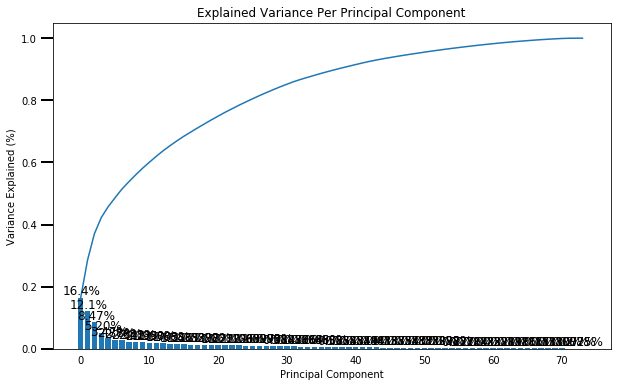

In [64]:
scree_plot(pca)

In [65]:
i = 0
while i < 75:
    i = i+5
    print('Explained variance for {} components:'.format(i), 
          pca.explained_variance_ratio_[:i].sum())

Explained variance for 5 components: 0.45747831202074063
Explained variance for 10 components: 0.5812256947600067
Explained variance for 15 components: 0.6694458391867637
Explained variance for 20 components: 0.7367841949115839
Explained variance for 25 components: 0.7944178919940728
Explained variance for 30 components: 0.8432039331159233
Explained variance for 35 components: 0.8803824692877357
Explained variance for 40 components: 0.9096662573473965
Explained variance for 45 components: 0.9337522412796199
Explained variance for 50 components: 0.9517161214604295
Explained variance for 55 components: 0.9670821411233385
Explained variance for 60 components: 0.9799861107517684
Explained variance for 65 components: 0.9903622222244375
Explained variance for 70 components: 0.9979068025282668
Explained variance for 75 components: 1.0


According to the value of the explained variance listed above, it looks like 

- more than 45% of the variance is captured by the first 5 components
- the increase of variance captured with additional components is relevant until getting to about 35 components
- with about half of the features, 90% of the variance is explained by the components. The increase of components does not bring a relevant increase of explained variance (less or much less than 1% per additional component).

Therefore, we are going to re-apply PCA with 35 components. 

In [66]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_35 = PCA(35)
azdias_pca_35 = pca_35.fit_transform(azdias_clean_std)

### Discussion 2.2: Perform Dimensionality Reduction

The first 5 components capture almost half of the variance. With 35 components, less than half of the number of features, almost 90% of the variance is captured.
We therefore decided to re-apply PCA with 35 components, allowing relevant dimensionality reduction while ensuring we are able to explain as much variance as possible. 


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [67]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def component_weight(pca, comp, dataset):
    pca_weights = {}
    
    # Populate a dictionary with the correspondance name of the feature and weight for the given component
    for feat in dataset:
        feat_index = dataset.columns.get_loc(feat)
        pca_weights[feat]=pca.components_[comp][feat_index]
    
    # Sort the values
    pca_weights = sorted(pca_weights.items(), key=itemgetter(1))
    
    #Create a dataframe from the dictionary obtained
    pca_weights = pd.DataFrame(pca_weights, columns = ['Feature', 'Weight'])
    pca_weights.set_index('Feature', inplace=True)
    return pca_weights

def plot_weights(weights):
    ax = weights.plot.bar()
    ax.set_xlabel("Feature", fontsize=12)
    ax.set_ylabel("Weight", fontsize=12)
    plt.title('Weights for the first and last five features')
    plt.show()
    

In [68]:
# We get the weights for the first principal component
pca_1_weights = component_weight(pca_35, 1, azdias_clean)
pca_1_weights

,Weight
Feature,
SEMIO_REL,-0.251325
PRAEGENDE_JUGENDJAHRE_DECADE,-0.240602
FINANZ_SPARER,-0.236110
FINANZ_UNAUFFAELLIGER,-0.227914
SEMIO_PFLICHT,-0.226761
SEMIO_TRADV,-0.226755
SEMIO_KULT,-0.210640
FINANZ_ANLEGER,-0.204983
SEMIO_FAM,-0.176537


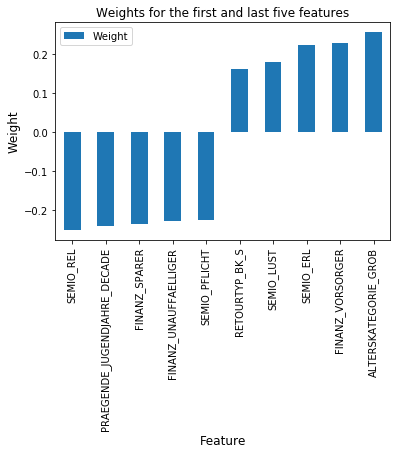

In [69]:
#Let's take a closer look at the first and last 5 features
weights_1 = pd.concat([pca_1_weights.head(5), pca_1_weights.tail(5)]) 
plot_weights(weights_1)

For this first component we notice that:

- the most meaningful features are:
    - SEMIO_REL (-) -> Personality typology (religious) 
    - PRAEGENDE_JUGENDJAHRE_DECADE (-) -> person's youth decade
    - FINANZ_SPARER (-) -> Financial typology (money-saver)
    - FINANZ_UNAUFFAELLIGER (-) -> Financial typology (inconspicuous)
    - SEMIO_PFLICHT (-) -> Personality typology (dutiful) 
    - RETOURTYP_BK_S (+) -> Return type
    - SEMIO_LUST (+) -> Personality typology (sensual-minded) 
    - SEMIO_ERL (+) -> Personality typology (event-oriented) 
    - FINANZ_VORSORGER (+) -> Financial typology (be prepared)
    - ALTERSKATEGORIE_GROB (+) -> Estimated age based on given name analysis
- the negative weights have a greater magnitude than the positive weights, therefore they are more correlated to the component
- the age of the person and the personality typology regarding religion almost directly influenced by each other

Overall, it seems that this first component describes the general behaviour of a person based on his/her age, analysing in particular the tendency of a person to be discrete, reserved, careful and honest with money - or its opposite. 
From the perspective of a business, this first component could be interesting to understand the relationship a person has with money, thus whether temptation (through ads for example), have a chance to catch. 

In [70]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_2_weights = component_weight(pca_35, 2, azdias_clean)
pca_2_weights


,Weight
Feature,
ANREDE_KZ,-0.362854
SEMIO_KAEM,-0.331121
SEMIO_DOM,-0.307332
SEMIO_KRIT,-0.272793
SEMIO_RAT,-0.202642
SEMIO_ERL,-0.183692
FINANZ_ANLEGER,-0.177456
SHOPPER_TYP,-0.122796
PRAEGENDE_JUGENDJAHRE_DECADE,-0.098577


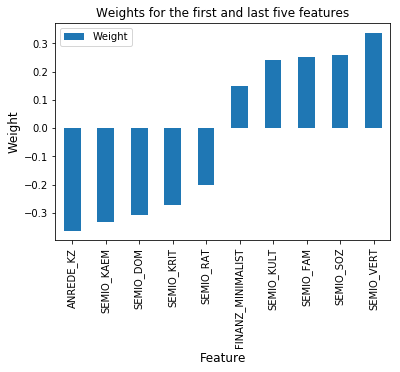

In [71]:
weights_2 = pd.concat([pca_2_weights.head(5), pca_2_weights.tail(5)]) 
plot_weights(weights_2)

For this second component, we notice that:

- the most meaningful features are:
    - ANREDE_KZ 
    - SEMIO_KAEM (-) -> Personality typology (combative attitude)
    - SEMIO_DOM (-) -> Personality typology (dominant-minded)
    - SEMIO_KRIT (-) -> Personality typology (critical-minded)
    - SEMIO_RAT (-) -> Personality typology (rational)
    - FINANZ_MINIMALIST -> Financial typology (low financial interest)
    - SEMIO_KULT (+) -> Personality typology (cultural-minded)
    - SEMIO_FAM (+) -> Personality typology (family-minded)
    - SEMIO_SOZ (+) -> Personality typology (socially-minded)
    - SEMIO_VERT (+) -> Personality typology (dreamful)
- the negative weights also have a greater magnitude than the positive weights, therefore they are more correlated to the component
- most features are focused on the personality typology of a person

Overall, it seems that this second component describes the personality of person, in particular his/her tendency to be extroverted, open-minded, stubborn, rational, and the interest in financial activities. 

From the perspective of a business, this second component could be interesting to understand if a person has the profile of a money-spender, and thus if it is a potential client. 


In [72]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_3_weights = component_weight(pca_35, 3, azdias_clean)
pca_3_weights

,Weight
Feature,
WOHNLAGE,-0.276616
BALLRAUM,-0.227300
KKK,-0.222913
INNENSTADT,-0.218436
HH_EINKOMMEN_SCORE,-0.214228
REGIOTYP,-0.168849
KONSUMNAEHE,-0.141058
W_KEIT_KIND_HH,-0.110207
ZABEOTYP,-0.109087


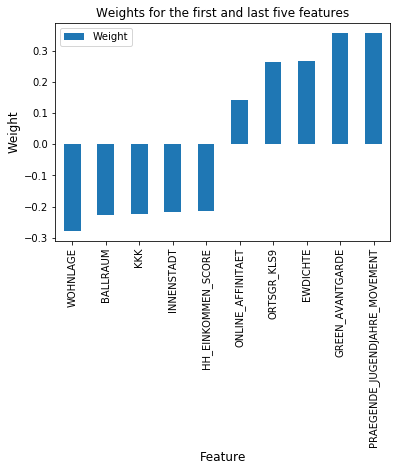

In [73]:
weights_3 = pd.concat([pca_3_weights.head(5), pca_3_weights.tail(5)]) 
plot_weights(weights_3)

For this third component, we notice that:
    
- the most meaningful features are:
    - WOHNLAGE (-) -> Neighborhood quality
    - BALLRAUM (-) -> Distance to nearest urban center
    - KKK (-) -> Purchasing power in region
    - INNENSTADT (-) -> Distance to city center
    - HH_EINKOMMEN_SCORE (-) -> Estimated household net income
    - ONLINE_AFFINITAET (+) -> Online affinity
    - ORTSGR_KLS9 (+) -> Size of community
    - EWDICHTE (+) -> Density of households per square kilometer
    - GREEN_AVANTGARDE (+) -> Membership in environmental sustainability as part of youth
    - PRAEGENDE_JUGENDJAHRE_MOVEMENT (+) -> person's youth mouvement (mainstream or avantgarde)
- both negative and positive weights have a magnitude that is comparable
- the features seem focused on the lifestyle and environment a person lives in.

Overall, it seems that this third component describes the relationship of a person with its environment, and his/her lifestyle, based on the youth mouvement (mainstream or avantgarde), the type of environment the person lives in (rural or urban and distance to urban center). 
From the perspective of a business, this third component could be interesting to understand if the lifestyle of a person, and his/her conviction regarding consumption are a match to be a customer. 


In [74]:
pca_4_weights = component_weight(pca_35, 4, azdias_clean)
weights_4 = pd.concat([pca_4_weights.head(5), pca_4_weights.tail(5)])
print(weights_4)

                     Weight
Feature                    
KBA13_ANZAHL_PKW  -0.408808
PLZ8_HHZ          -0.391512
PLZ8_GBZ          -0.354481
W_KEIT_KIND_HH    -0.247968
OST_WEST_KZ       -0.223458
ONLINE_AFFINITAET  0.170569
ARBEIT             0.182058
KKK                0.196696
ANZ_PERSONEN       0.268148
LP_FAMILIE_GROB    0.276549


In [75]:
pca_5_weights = component_weight(pca_35, 5, azdias_clean)
weights_5 = pd.concat([pca_5_weights.head(5), pca_5_weights.tail(5)])
print(weights_5)

                    Weight
Feature                   
W_KEIT_KIND_HH   -0.274603
KBA05_ANTG2      -0.225724
KBA05_GBZ        -0.203051
ARBEIT           -0.186389
MOBI_REGIO       -0.181321
KBA05_ANTG4       0.275345
PLZ8_HHZ          0.287183
KBA13_ANZAHL_PKW  0.308561
ANZ_PERSONEN      0.324178
LP_FAMILIE_GROB   0.328962


### Discussion 2.3: Interpret Principal Components

We took a closer look at the first three components, and in particular we plotted the weights for the first and last five features (features with the biggest positive and negative weights).

If we look at the first component, for example, we notice that:

- the most meaningful features are:
    - SEMIO_REL (-) -> Personality typology (religious) 
    - PRAEGENDE_JUGENDJAHRE_DECADE (-) -> person's youth decade
    - FINANZ_SPARER (-) -> Financial typology (money-saver)
    - FINANZ_UNAUFFAELLIGER (-) -> Financial typology (inconspicuous)
    - SEMIO_PFLICHT (-) -> Personality typology (dutiful) 
    - RETOURTYP_BK_S (+) -> Return type
    - SEMIO_LUST (+) -> Personality typology (sensual-minded) 
    - SEMIO_ERL (+) -> Personality typology (event-oriented) 
    - FINANZ_VORSORGER (+) -> Financial typology (be prepared)
    - ALTERSKATEGORIE_GROB (+) -> Estimated age based on given name analysis
- based on the interpretation of each feature of this list, we concluded that this component characterizes the relationship of a person with money based on his/her age (saver, easily tempted, honest....)

Now let's take a look at the second component:

- the most meaningful features are:
    - ANREDE_KZ 
    - SEMIO_KAEM (-) -> Personality typology (combative attitude)
    - SEMIO_DOM (-) -> Personality typology (dominant-minded)
    - SEMIO_KRIT (-) -> Personality typology (critical-minded)
    - SEMIO_RAT (-) -> Personality typology (rational)
    - FINANZ_MINIMALIST
    - SEMIO_KULT (+) -> Personality typology (cultural-minded)
    - SEMIO_FAM (+) -> Personality typology (family-minded)
    - SEMIO_SOZ (+) -> Personality typology (socially-minded)
    - SEMIO_VERT (+) -> Personality typology (dreamful)
- based on the interpretation of each feature of this list, we concluded that this component characterizes the personality of person, in particular his/her tendency to be extroverted, open-minded, stubborn, rational, and the interest in financial activities. 

And finally, let's look at the third component:

- the most meaningful features are:
    - WOHNLAGE (-) -> Neighborhood quality
    - BALLRAUM (-) -> Distance to nearest urban center
    - KKK (-) -> Purchasing power in region
    - INNENSTADT (-) -> Distance to city center
    - HH_EINKOMMEN_SCORE (-) -> Estimated household net income
    - ONLINE_AFFINITAET (+) -> Online affinity
    - ORTSGR_KLS9 (+) -> Size of community
    - EWDICHTE (+) -> Density of households per square kilometer
    - GREEN_AVANTGARDE (+) -> Membership in environmental sustainability as part of youth
    - PRAEGENDE_JUGENDJAHRE_MOVEMENT (+) -> person's youth mouvement (mainstream or avantgarde)
- based on the interpretation of each feature of this list, we concluded that this component characterizes the relationship of a person with its environment, and his/her lifestyle, based on the youth mouvement (mainstream or avantgarde), the type of environment the person lives in (rural or urban and distance to urban center). 
    
Taking a quick look at the next two components, we manage to interpret that they both are oriented towards the family, the closer environment (microcell).

So to summarize, with the 5 first components (that we said explain about 45% of the variance) we have the following interpretations:

- insight on the relationship of a person with money
- insight on the personality of a person and his/her tendency to spend money
- insight on the environment at a large scale (neighborhood)
- insight on the environment at a smaller scale (family, microcell)


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [76]:
# Over a number of different cluster counts...
    # run k-means clustering on the data and...
    # compute the average within-cluster distances.
    
def compute_kmeans(n_centers, dataset):
    kmeans = KMeans(n_clusters=n_centers)
    model = kmeans.fit(dataset)
    return model

def kmeans_score(model, dataset):
    score = np.abs(model.score(dataset))
    return score

In [77]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.


In [78]:
# We calculate the score of KMeans based on the number of centers

k_range = range(1, 25)
scores = []

for k in k_range:
    kmeans_k = compute_kmeans(k, azdias_pca_35)
    score = kmeans_score(kmeans_k, azdias_pca_35)
    scores.append(score)

print(scores)

[51946209.06107169, 44642755.33632583, 41127540.7951622, 38923472.68724131, 37451579.482698165, 36148490.90231061, 35009017.11784998, 34068207.71791048, 33368468.622905612, 32646960.96844662, 32173836.726182394, 31869527.582458287, 31217560.584820025, 30924038.56747063, 30611108.600256473, 30360133.445137516, 29926302.2667852, 29448649.756806403, 29031275.076947235, 28780279.33807156, 28527801.372992486, 28162784.60858898, 28156341.624021735, 27755874.164035928]


In [79]:
# Function to plot the elbow plot

def plot_elbow(scores):
    x = range(1, len(scores)+1)
    plt.figure(figsize=(8, 4))
    plt.plot(x, scores, marker='o')
    plt.xticks(x)
    plt.xlabel('K')
    plt.ylabel('SSE');


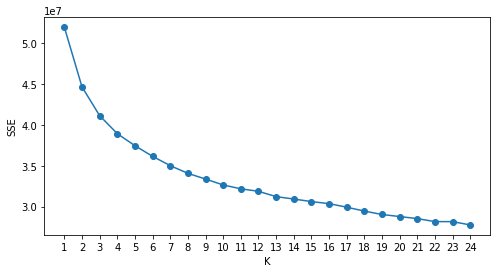

In [80]:
plot_elbow(scores)

In [81]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans_12 = compute_kmeans(12, azdias_pca_35)

In [82]:
clust_azdias = kmeans_12.predict(azdias_pca_35)

### Discussion 3.1: Apply Clustering to General Population

We calculated the score of KMeans for several number of centers. We plotted the elbow curve, showing the value of this score depending on k. 

It seemed that from k = 12 the slope really starts decreasing. We therefore used this value to re-fit the model, and split the population into 12 groups.


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [86]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", delimiter=";")

In [87]:
customers.shape

(191652, 85)

In [88]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

# Applying preprocessing to the data
customers_clean = clean_data(customers, feat_info)

/Users/acoullandreau/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/acoullandreau/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/acoullandreau/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

In [89]:
customers_clean.shape

(141640, 74)

Note: in our function, we were dropping features when their ratio of missing values was above 30%. 
It occured that the customers dataset has two features with more than the demographic dataset:
- KKK (31.340137)
- REGIOTYP (31.340137)

We therefore adjusted this percentage to have the two dataset matching shapes (the number of features is the same after this preprocessing step, although the number of rows varies).

In [92]:
# Applying feature transformation to the data

#num_list was stored when fitting the imputer to the azdias_clean dataset
customers_clean[customers_clean.columns.intersection(num_list)] = num_imp.transform(customers_clean[customers_clean.columns.intersection(num_list)])


In [93]:
#cat_list and new_feat_list was stored when fitting the imputer to the azdias_clean dataset
customers_clean[customers_clean.columns.intersection(cat_list)] = cat_imp.transform(customers_clean[customers_clean.columns.intersection(cat_list)])
customers_clean[customers_clean.columns.intersection(new_feat_list)] = new_feat_imp.transform(customers_clean[customers_clean.columns.intersection(new_feat_list)])


In [94]:
customers_clean_std = scaler.transform(customers_clean)

/Users/acoullandreau/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [95]:
customers_clean.isnull().sum().sum()

0

In [96]:
# Applying clustering to the data
customers_pca = pca_35.transform(customers_clean_std)

In [98]:
clust_customers = kmeans_12.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [99]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# We convert the counts for each cluster into a percentage to observe the proportions

azdias_prop = []
customer_prop = []

for k in range(1, 12):
    azdias_prop.append((clust_azdias == k).sum()/len(clust_azdias))
    customer_prop.append((clust_customers == k).sum()/len(clust_customers))

clusters_prop = pd.DataFrame({'Proportions azdias':azdias_prop, 'Proportions customers':customer_prop})

In [100]:
clusters_prop

,Proportions azdias,Proportions customers
0,0.106407,0.009856
1,0.102600,0.180457
2,0.108929,0.100706
3,0.074747,0.019493
4,0.112894,0.088690
5,0.054632,0.038012
6,0.073476,0.119225
7,0.103025,0.014530
8,0.073054,0.333317
9,0.008413,0.009821


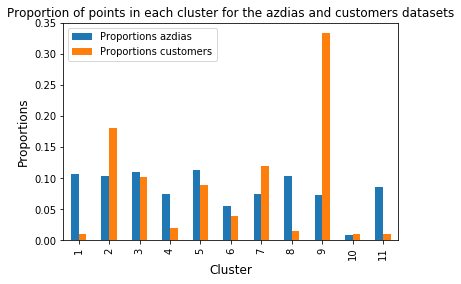

In [101]:
ax = clusters_prop.plot.bar()
ax.set_xlabel("Cluster", fontsize=12)
ax.set_ylabel("Proportions", fontsize=12)
plt.xticks(np.arange(len(clusters_prop)), np.arange(1, len(clusters_prop)+1))
plt.title('Proportion of points in each cluster for the azdias and customers datasets')
plt.show()


In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

It looks like both clusters 2 and 9 are overrepresented in the customer data compared to the general population. Let's take a look at the kind of people we find in those two clusters.

In [103]:
cluster_2 = scaler.inverse_transform(pca_35.inverse_transform(kmeans_12.cluster_centers_[1]))
cluster_2 = pd.Series(data = cluster_2, index = customers_clean.columns)

In [105]:
cluster_9 = scaler.inverse_transform(pca_35.inverse_transform(kmeans_12.cluster_centers_[8]))
cluster_9 = pd.Series(data = cluster_9, index = customers_clean.columns)

In [106]:
clusters_over = pd.DataFrame({'Cluster 2':cluster_2, 'Cluster 9':cluster_9})

In [107]:
clusters_over

,Cluster 2,Cluster 9
ALTERSKATEGORIE_GROB,1.704577,1.796244
ANREDE_KZ,1.999587,1.958405
CJT_GESAMTTYP,4.121699,4.054523
FINANZ_MINIMALIST,1.154713,2.315285
FINANZ_SPARER,4.300850,3.989012
FINANZ_VORSORGER,2.205724,2.266667
FINANZ_ANLEGER,4.135872,4.422295
FINANZ_UNAUFFAELLIGER,3.829552,3.910288
FINANZ_HAUSBAUER,4.198084,2.831441
FINANZTYP,2.023954,2.420698


Let's look at some relevant features to figure out the kind of people we find in those two clusters:

- ALTERSKATEGORIE_GROB (Estimated age) : around 30 years old
- ANREDE_KZ (Gender) : mainly females
- FINANZTYP (Financial type) : money-saver - i.e. probably not inclined to spend money randomly, but for targetted purposes
- LIFE_STAGE : Young Couples With Children / Families With School Age Children (which is coherent with the estimated age range)
- NATIONALITAET_KZ (Nationality based on given name analysis) : German-sounding
- Personality typology: socially-minded, family-minded, dreamful
- HH_EINKOMMEN_SCORE (Estimated household net income) : lower/average household income
- WOHNLAGE (Neighborhood quality) : rather poor neighborhood (which is coherent with the income level)
- CAMEO_DEUG_2015 (Wealth / Life Stage Typology): consumption-oriented middleclass / lower middleclass
- KKK (Purchasing power) : average/high
- MOBI_REGIO (Movement patterns): high
- ONLINE_AFFINITAET (Online affinity): middle/high

Globally, we can conclude from this first analysis that the clusters overrepresented in the customer data regroup young females, mostly from the Germany middle-class, money-savers although consumption-oriented, with a high movement pattern (not settled).

In [120]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?


Let's perform a similar analysis on the underrepresented clusters.
It looks like clusters 1, 8 and 11 are underrepresented in the customer data compared to the general population. Let's take a look at the kind of people we find in those three clusters.

In [108]:
cluster_1 = scaler.inverse_transform(pca_35.inverse_transform(kmeans_12.cluster_centers_[0]))
cluster_1 = pd.Series(data = cluster_1, index = customers_clean.columns)

In [121]:
cluster_4 = scaler.inverse_transform(pca_35.inverse_transform(kmeans_12.cluster_centers_[3]))
cluster_4 = pd.Series(data = cluster_4, index = customers_clean.columns)

In [109]:
cluster_8 = scaler.inverse_transform(pca_35.inverse_transform(kmeans_12.cluster_centers_[7]))
cluster_8 = pd.Series(data = cluster_8, index = customers_clean.columns)

In [110]:
cluster_11 = scaler.inverse_transform(pca_35.inverse_transform(kmeans_12.cluster_centers_[10]))
cluster_11 = pd.Series(data = cluster_11, index = customers_clean.columns)

In [122]:
clusters_under = pd.DataFrame({'Cluster 1':cluster_1, 'Cluster 4':cluster_4,'Cluster 8':cluster_8, 'Cluster 11':cluster_11})

In [123]:
clusters_under

,Cluster 1,Cluster 4,Cluster 8,Cluster 11
ALTERSKATEGORIE_GROB,3.504860,3.324454,3.340258,2.775774
ANREDE_KZ,1.927500,1.042392,1.957049,1.513148
CJT_GESAMTTYP,3.039075,3.330875,3.471004,3.547790
FINANZ_MINIMALIST,3.697555,3.420801,4.098188,3.114965
FINANZ_SPARER,1.828799,1.947648,1.757500,2.713924
FINANZ_VORSORGER,4.106200,4.209697,4.061611,3.435965
FINANZ_ANLEGER,2.904230,1.642546,2.226216,2.853231
FINANZ_UNAUFFAELLIGER,1.956682,1.731764,2.310218,2.696985
FINANZ_HAUSBAUER,2.781697,3.434159,2.323082,3.058003
FINANZTYP,4.294059,5.089859,4.123298,3.800042


Let's look at some relevant features to figure out the kind of people we find in those three clusters:

- ALTERSKATEGORIE_GROB (Estimated age) : 46-60 years old
- ANREDE_KZ (Gender) : indifferently males and females
- FINANZTYP (Financial type) : home-ownership, investor and prepared - i.e. settled and probably inclined to invest in a variety of financial activities
- LIFE_STAGE : Families With School Age Children (which is coherent with the estimated age range)
- NATIONALITAET_KZ (Nationality based on given name analysis) : German-sounding
- Personality typology: tradional-minded, dutiful, rational, religious
- HH_EINKOMMEN_SCORE (Estimated household net income) : average household income
- WOHNLAGE (Neighborhood quality) : average neighborhood
- CAMEO_DEUG_2015 (Wealth / Life Stage Typology): middleclass
- KKK (Purchasing power) : high
- MOBI_REGIO (Movement patterns): middle
- ONLINE_AFFINITAET (Online affinity): middle

Globally, we can conclude from this first analysis that the clusters underrepresented in the customer data regroup middle-aged males and females, rather traditional, mostly from the Germany middle-class, settled, and inclined to consumption. 

### Discussion 3.3: Compare Customer Data to Demographics Data

We plotted a graph showing the proportion of points belonging to each cluster for the two datasets (demographic azdias and customers). 
We can clearly distinguish three situations:

- for some clusters, the proportion of people in the customers dataset is higher than for the demographic dataset
    - cluster 2
    - cluster 9
- for some clusters, it is the inverse, with the proportion of people in the customers dataset lower than for the demographic dataset
    - cluster 1
    - cluster 4
    - cluster 8
    - cluster 11
- for the other clusters, the proportions are quite similar
    - cluster 3
    - cluster 5
    - cluster 6
    - cluster 7
    - cluster 10
    

We took a closer look at the clusters overrepresented and underrepresented in the customers data.
It appeared that:

- the population relatively popular with the mail-order company (from the overrepresented clusters) is young females, mostly from the Germany middle-class, money-savers although consumption-oriented, with a high movement pattern (not settled).
- the population relatively inpopular with the mail-order company (from the underrepresented clusters) is middle-aged males and females, rather traditional, mostly from the Germany middle-class, settled, and inclined to consumption.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.